In [2]:
using PyPlot

# Fourier Spectral Methods (aka Planewaves)

by [Christoph Ortner](http://homepages.warwick.ac.uk/staff/C.Ortner/)  
last update 26 June 2014  
tested ok on Julia 0.3.10
tested ok on Julia 0.5-dev (but animations don't work anymore)

All examples in this notebook implement a Fourier spectral method for solving a (partial) differential equation with periodic boundary conditions.
 
**Acknowledgements:**

* Codes are built from a `Matlab` example by Simon Bignold (PhD student at Warwick U.)

## 1. A Few Quick 1D Examples

### 1.1 BVP Solver
We start out by solving a simple linear bvp 
$$
- u'' + u = f(x), \qquad x \in (-\pi, \pi)
$$
Expanding $u(x) = \sum_{k \in \mathbb{Z}} \hat{u}(k) e^{i k x}$, the equation in reciprocal space becomes diagonal, 
$$
   (|k|^2+1) \hat{u}(k) = \hat{f}(k), \qquad k \in \mathbb{Z}.
$$
Projection to a finite set of $k$ values yields the following short code snippet. 

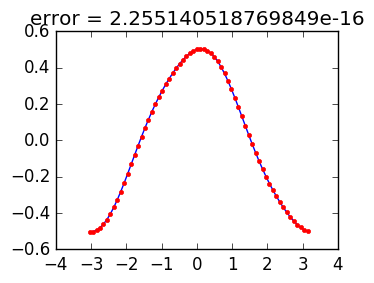

In [3]:
# grid parameters
N = 2^6
h = 2*pi / N
# real-space grid
x = collect(linspace(-pi+h, pi, N))
# reciprocal space grid
k = [0:N/2; -N/2+1:-1]
# right-hand side
f = cos(x) + 0.2 * sin(3*x)
# multiplier for derivative operator
D̂ = - im * k
# solve the BVP in Fourier space
û = fft(f) ./ (1-D̂.^2)
# transform back
u = real(ifft(û))
u_exact = cos(x) / (1+1^2) + 0.2 * sin(3*x) / (1+3^2)

# output solution
subplot(2,2,1)
plot(x, u, "b-", x, u_exact, "r.")
title(string("error = ", norm(u-u_exact, Inf)));

### 1.2 Allen-Cahn Equation

In the next example, we implement a spectral method for the Allen--Cahn equation,
$$ u_t = \epsilon u_{xx} - \frac{1}{\epsilon} (u^3 - u), $$
again supplemented with PBCs and a random initial condition. We use a semi-implicit Euler method in time, which yields
$$
  u^{[n+1]} - \tau \epsilon u_{xx}^{[n+1]} = u^{[n]} - \frac{\tau}{\epsilon} \big( (u^{[n]})^3 - u^{[n]} \big).
$$
In reciprocal space, the time-step equation becomes again diagonal:
$$
  (1 + \tau \epsilon |k|^2) \hat{u}^{(n+1)}(k) = \hat{u}(k) - \frac{\tau}{\epsilon} \widehat{((u^{[n]})^3 - u^{[n]}})(k).
$$

In [5]:
# grid parameters
N = 2^7
h = 2*pi / N
tau = h/4
epsn = 2/10
# real-space grid
x = linspace(-pi+h, pi, N)
# reciprocal space grid
k = [0:N/2; -N/2+1:-1]

# construct initial condition
u = 2*(rand(N) - 0.5)

# Plotting setup
pygui(true); PyPlot.ion(); PyPlot.hold(false)

# multiplier
Â = 1 + tau * epsn * k.^2

# time-stepping
for n = 1:ceil(2/tau)
    u = real(ifft( fft(u - tau/epsn * (u.^3-u)) ./ Â )) 
    # plot
    plot(x, u)
    axis([-pi, pi, -1.1, 1.1])
    title(string(" t = ", round(n * tau,2)))
    PyPlot.draw()
end


2016-07-02 07:32:32.065 julia[9656:1094815] setCanCycle: is deprecated.  Please use setCollectionBehavior instead
2016-07-02 07:32:32.072 julia[9656:1094815] setCanCycle: is deprecated.  Please use setCollectionBehavior instead


## 2. A 2D Cahn-Hilliard Solver

The Cahn--Hilliard equation reads
$$ (-\Delta)^{-1} u_t = \epsilon \Delta u - \frac{1}{\epsilon} (u^3 - u) $$
The difficulty here is that a trivial semi-implicit time discretisation
$$
   u^{(n+1)} + \epsilon \tau \Delta^2 u^{(n+1)} = u^{(n)} + \frac{\tau}{\epsilon} \Delta (u^3 - u)
$$
has time-step restriction $O( \epsilon h^2 )$. We can stabilise with a (local) convex-concave splitting such as
$$
   (1 + \epsilon \tau \Delta^2 - C \tau \Delta) u^{(n+1)} 
    = (1-C \tau \Delta) u^{(n)} + \frac{\tau}{\epsilon} \Delta (u^3 - u)^{(n)}.
$$
Since $(u^3-u)' = 3 u^2 - 1 \in [-1, 2]$ so we need $C \geq 2/\epsilon$ to get $\tau$-independent stability. We then choose the time-step $\tau = h \epsilon$ to make up for the loss of accuracy.

In reciprocal space, the time step equation becomes
$$
  (1+\epsilon \tau |k|^4 + C \tau |k|^2) \hat{u}^{(n+1)} = \big(1+C\tau |k|^2 + \frac{\tau}{\epsilon} |k|^2\big) \hat{u}^{(n)} - \frac{\tau}{\epsilon} |k|^2 (\widehat{u^3})^{(n)}
$$

(For something more serious we should probably implement a decent adaptive time-stepping strategy.)

In [11]:
# grid parameters: 2π x 2π
N = 2^7
h = 2*π/N
epsn = h * 3
C = 2/epsn
tau = epsn * h
Tfinal = 4

# real-space and reciprocal-space grids
# the real-space grid is just used for plotting!
X = collect(linspace(h, 2*pi, N)) .* ones(1,N)
k = collect([0:N/2; -N/2+1:-1])
# -Δ multiplier
Â = kron(k.^2, ones(1,N)) + kron(ones(N), k'.^2)

# Plotting setup
using PyPlot
pygui(true); PyPlot.ion(); PyPlot.hold(false)

# initial condition
u = 2*(rand(N, N)-0.5)

# time-stepping loop
T_plot = 0.01; t_plot = 0.0
for n = 1:ceil(Tfinal / tau)
    # STEP: in this version we just use vectorised Matlab-style, 
    #       but see the next section on how we could speed this
    #       up if we wanted to
    u = real(ifft( ( (1+C*tau*Â).*fft(u) - tau/epsn * (Â .* fft(u.^3-u))) ./ (1+(epsn*tau)*Â.^2+C*tau*Â) ))
    
    # PLOT:
    t_plot += tau
    if t_plot >= T_plot
        contourf(X, X', u, rstride=4, cstride=4, cmap=ColorMap("rainbow"), 
                linewidth=0.0, levels = linspace(-1.1,1.1,15))
        axis([0, 2*pi, 0, 2*pi]);
        title(string(" t = ", round(n * tau,2)))
        PyPlot.draw()
        t_plot = 0.0
    end
end


2016-07-02 07:38:24.767 julia[9656:1094815] setCanCycle: is deprecated.  Please use setCollectionBehavior instead
2016-07-02 07:38:24.775 julia[9656:1094815] setCanCycle: is deprecated.  Please use setCollectionBehavior instead


-------------
### Everything below this cell has not been tested on v0.5!
-------------

## 3 Some Performance optimisations

This is a good opportunity to play around with some profiling and optimisation. Let us start by wrapping the CH_stepper into a function and `@time` it.

In [5]:
# here is the vectorised version from above
function CH_vectorised!(nruns, N)

    # initialisations
    h = 2*π/N; epsn = h * 3; C = 2/epsn; tau = epsn * h
    k = [0:N/2, -N/2+1:-1]
    Â = kron(k.^2, ones(1,N)) + kron(ones(N), k'.^2)
    u = 2*(rand(N, N)-0.5)
    
    # ============= ACTUAL CODE THAT IS BEING TESTED ======================
    for n = 1:nruns
        # Matlab/Python-style
        u[:,:] = real(ifft( 
                ( (1+C*tau*Â).*fft(u) - tau/epsn * (Â .* fft(u.^3-u))) 
                    ./ (1+(epsn*tau)*Â.^2+C*tau*Â) ))
    end
    # ======================================================================
end

CH_vectorised!(3, 2^8)
@time CH_vectorised!(30, 2^8)

elapsed time: 0.7056573 seconds (412378760 bytes allocated, 39.61% gc time)


A disproportionate amount of data is being allocated. 30% GC time is not so terrible, but in reality, almost everything could be done in-place. Unfortunately, at this stage we need to do a lot by hand to achieve this. The following variant moves all `fft` calls to `fft!` calls and replaces the vectorised operations by loops. If we put an `@time` in front of the `for` loop then we would find that no memory at all is allocated within the loop.

RESULT: we roughly gain a factor 2 to 3 in speed. This is not necessary for quick testing, but useful when we implement something bigger.

**Remark: **  We might be tempted to not allocate $\hat{A}$ either. Indeed, this would require us to allocate $25\%$ less memory, but also slightly slows us down, probably because the entries need to be recomputed, but maybe also because the single-loop would become a double-loop?

In [6]:

# an optimised implementation of CH_vectorised!
function CH_memory!(nruns, N)
    
    # initialisations
    h = 2*π/N; epsn = h * 3; C = 2/epsn; tau = epsn * h
    k = [0:N/2, -N/2+1:-1]
    Â = kron(k.^2, ones(1,N)) + kron(ones(N), k'.^2)
    u = 2*(rand(N, N)-0.5)
    
    
    # ============= ACTUAL CODE THAT IS BEING TESTED ======================
    # allocate arrays and define constants
    N = size(u, 1)
    w = complex(u)
    v = copy(w)
    c1 = C*tau+tau/epsn
    c2 = tau/epsn
    c3 = epsn*tau
    c4 = C*tau
    
    # we could also add an @inbound macro since we are sure
    # that all loops are properly bounded, but this buys us
    # nothing here
    for n = 1:nruns
        for i = 1:length(v); v[i] = u[i]*u[i]*u[i]; end
        fft!(v)
        fft!(w)
        for i = 1:length(w)
            w[i] = ((1+c1*Â[i])*w[i] - (c2*Â[i])*v[i]) / ((1+c3*Â[i]+c4)*Â[i])
        end
        ifft!(w)
        for i = 1:length(u); u[i] = real(w[i]); end
    end
    # ======================================================================
end


# run two timing tests

println("Testing with N = 2^8")
N = 2^8; nruns = 100
CH_vectorised!(ceil(nruns/10), N)
@time CH_vectorised!(nruns, N)
CH_memory!(ceil(nruns/10), N)
@time CH_memory!(nruns, N)
println("=========================")
println("Testing with N = 2^9")
N = 2^9; nruns = 30
CH_vectorised!(ceil(nruns/10), N)
@time CH_vectorised!(nruns, N)
CH_memory!(ceil(nruns/10), N)
@time CH_memory!(nruns, N)



Testing with N = 2^8
elapsed time: 2.443473127 seconds (1367177360 bytes allocated, 42.58% gc time)
elapsed time: 0.584224252 seconds (6910576 bytes allocated)
Testing with N = 2^9
elapsed time: 2.962735259 seconds (1648696000 bytes allocated, 44.46% gc time)
elapsed time: 0.818214813 seconds (21170240 bytes allocated, 5.76% gc time)


**Final test:** the `Devectorize` package can actually do a fair bit of work for us. Unfortunately, it does not recognize the function `real`, so we need to devectorise it by hand, and it also needs to be told explicitly to do the operations in-place,by using the [:,:] notation. The result runs about 5-10% slower than the "hand-optimised" version, which is perfectly acceptable. Possibly this comes from the fact that we devectorize an operation on matrices rather than vectors?

In [7]:
using Devectorize

# testing the devectorise macro
# using plan_fft to speed up the FFTs?
function CH_devec!(nruns, N)
    
    # initialisations
    h = 2*π/N; epsn = h * 3; C = 2/epsn; tau = epsn * h
    k = [0:N/2, -N/2+1:-1]
    Â = kron(k.^2, ones(1,N)) + kron(ones(N), k'.^2)
    u = 2*(rand(N, N)-0.5)
    
    
    # ============= ACTUAL CODE THAT IS BEING TESTED ======================
    # allocate arrays and define constants
    N = size(u, 1)
    w = complex(u)
    v = copy(w)
    c1 = C*tau+tau/epsn
    c2 = tau/epsn
    c3 = epsn*tau
    c4 = C*tau

    for n = 1:nruns
        @devec v[:,:] = u.*u.*u
        fft!(v)
        fft!(w)
        @devec w[:,:] = ((1+c1.*Â).*w - (c2.*Â).*v) ./ (((1+c4)+c3.*Â).*Â)
        ifft!(w)
        for i = 1:length(u); u[i] = real(w[i]); end
    end
    # ======================================================================
end

N = 2^9; nruns = 30
CH_devec!(ceil(nruns/10), N)
@time CH_devec!(nruns, N)




elapsed time: 0.835390443 seconds (22817132 bytes allocated, 4.58% gc time)
